<a href="https://colab.research.google.com/github/shubham-819/Colouring-Images/blob/main/COLORIZING_IMAGES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DOWNLOADING THE DATASET (KAGGLE API)

In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d prasunroy/natural-images
!unzip "/content/natural-images.zip"


Streaming output truncated to the last 5000 lines.
  inflating: natural_images/cat/cat_0204.jpg  
  inflating: natural_images/cat/cat_0205.jpg  
  inflating: natural_images/cat/cat_0206.jpg  
  inflating: natural_images/cat/cat_0207.jpg  
  inflating: natural_images/cat/cat_0208.jpg  
  inflating: natural_images/cat/cat_0209.jpg  
  inflating: natural_images/cat/cat_0210.jpg  
  inflating: natural_images/cat/cat_0211.jpg  
  inflating: natural_images/cat/cat_0212.jpg  
  inflating: natural_images/cat/cat_0213.jpg  
  inflating: natural_images/cat/cat_0214.jpg  
  inflating: natural_images/cat/cat_0215.jpg  
  inflating: natural_images/cat/cat_0216.jpg  
  inflating: natural_images/cat/cat_0217.jpg  
  inflating: natural_images/cat/cat_0218.jpg  
  inflating: natural_images/cat/cat_0219.jpg  
  inflating: natural_images/cat/cat_0220.jpg  
  inflating: natural_images/cat/cat_0221.jpg  
  inflating: natural_images/cat/cat_0222.jpg  
  inflating: natural_images/cat/cat_0223.jpg  
  inflati

In [3]:

!rm -rf /content/natural_images

#IMPORTING LIBRARIES

In [7]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.utils.image_utils import img_to_array, array_to_img, load_img
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from math import log10, sqrt
import cv2
import numpy as np
import PIL
from PIL import Image
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import shutil
import keras
from keras.preprocessing import image
from keras.layers import Conv2D, Conv3D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.callbacks import TensorBoard
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
from time import time
import numpy as np
import os
import random
import tensorflow as tf
from PIL import Image, ImageFile

#ENCODER (TRANSFER LEARNING)

In [8]:
vggmodel = keras.applications.vgg16.VGG16()
newmodel = Sequential()
num = 0
for i, layer in enumerate(vggmodel.layers):
    if i<19:
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [10]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
train = train_datagen.flow_from_directory('/content/data/natural_images', target_size=(224, 224),batch_size=1200,class_mode=None)

X =[]
Y =[]


count = 0
for img in train[0]:
  print(count)
  count += 1
  lab = rgb2lab(img)
  X.append(lab[:,:,0])
  Y.append(lab[:,:,1:] / 128)

X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,))
print(X.shape)
print(Y.shape)

Found 6899 images belonging to 8 classes.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266


In [11]:
vggfeatures = []
for i, sample in enumerate(X):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

1/1 [==============================] - 0s 25ms/step
(1200, 7, 7, 512)


#DECODER

In [12]:
#Encoder
encoder_input = Input(shape=(7, 7, 512,))
#Decoder
decoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_input)
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=encoder_input, outputs=decoder_output)

#FITTING AND TRAINING THE AUTOENCODER

In [13]:
model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])

history = model.fit(vggfeatures, Y, verbose=1, epochs=100)

Epoch 1/100
38/38 [==============================] - 7s 37ms/step - loss: 0.2125 - accuracy: 0.5188
Epoch 2/100
38/38 [==============================] - 1s 29ms/step - loss: 0.0140 - accuracy: 0.6124
Epoch 3/100
38/38 [==============================] - 1s 35ms/step - loss: 0.0132 - accuracy: 0.6268
Epoch 4/100
38/38 [==============================] - 1s 35ms/step - loss: 0.0127 - accuracy: 0.6280
Epoch 5/100
38/38 [==============================] - 1s 26ms/step - loss: 0.0122 - accuracy: 0.6349
Epoch 6/100
38/38 [==============================] - 1s 21ms/step - loss: 0.0117 - accuracy: 0.6401
Epoch 7/100
38/38 [==============================] - 1s 21ms/step - loss: 0.0112 - accuracy: 0.6463
Epoch 8/100
38/38 [==============================] - 1s 20ms/step - loss: 0.0107 - accuracy: 0.6541
Epoch 9/100
38/38 [==============================] - 1s 21ms/step - loss: 0.0102 - accuracy: 0.6598
Epoch 10/100
38/38 [==============================] - 1s 21ms/step - loss: 0.0099 - accuracy: 0.6606

1/1 [==============================] - 0s 20ms/step


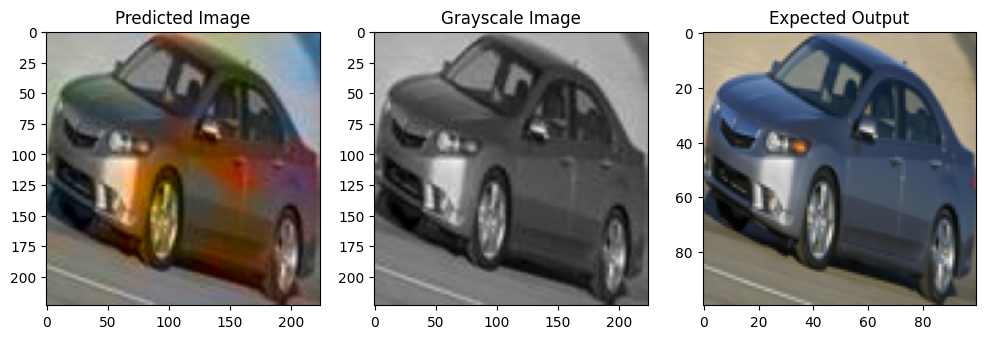

In [17]:
ind = '0277'

pth = '/content/data/natural_images/car/car_0274.jpg'.format(ind)

T = np.array(Image.open(pth))

g_img = Image.open(pth).convert('L')

test = g_img.save("test.jpg")

files = ['test.jpg']
for idx, file in enumerate(files):
    test = img_to_array(load_img(file))
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    vggpred = newmodel.predict(L)
    ab = model.predict(vggpred)
    ab = ab*255
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12, 12)
axes[0].set_title('Predicted Image')
im0 = axes[0].imshow(lab2rgb(cur))
axes[1].set_title('Grayscale Image')
im1 = axes[1].imshow(test)
axes[2].set_title('Expected Output')
im2 = axes[2].imshow(T)



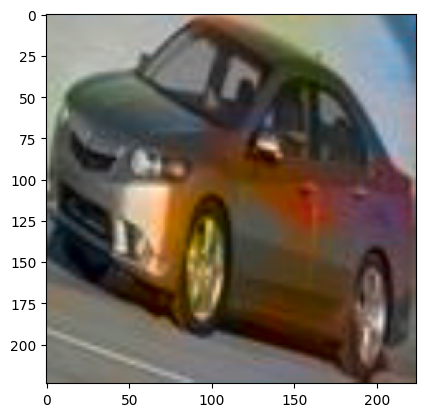

In [18]:
plt.imshow(lab2rgb(cur))

Text(0, 0.5, 'Accuracy')

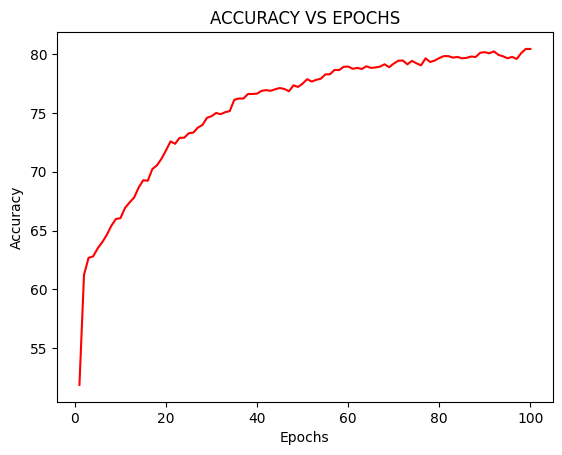

In [19]:
import seaborn as sns
x = [i for i in range(1, 101)]
y = [i*100 for i in history.history['accuracy']]

plt.plot(x, y, color = 'r')
plt.style.use(['dark_background'])
plt.title("ACCURACY VS EPOCHS")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

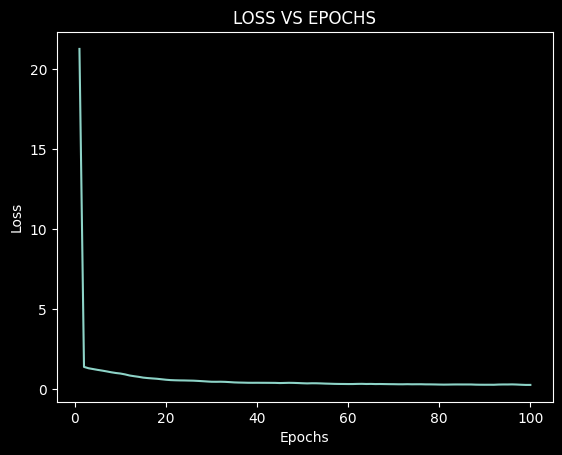

In [20]:
x = [i for i in range(1, 101)]
y = [i*100 for i in history.history['loss']]

plt.plot(x, y)
plt.title("LOSS VS EPOCHS")
plt.xlabel("Epochs")
plt.ylabel("Loss")

1/1 [==============================] - 0s 43ms/step


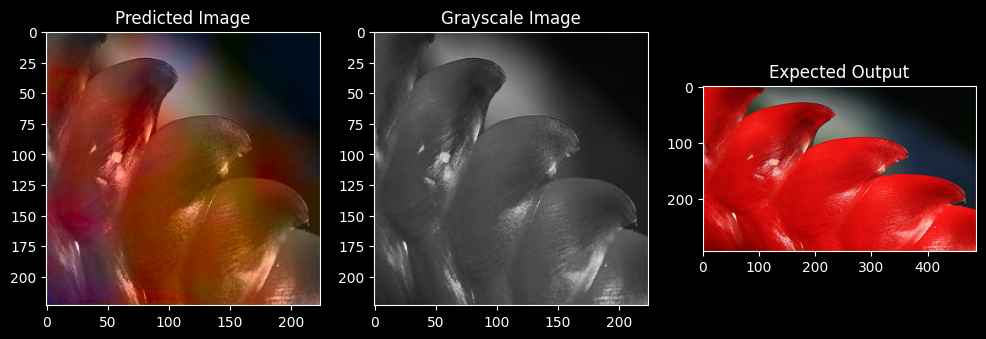

In [21]:
pth = '/content/data/natural_images/flower/flower_0014.jpg'.format(ind)

T = np.array(Image.open(pth))

g_img = Image.open(pth).convert('L')

test = g_img.save("test.jpg")

files = ['test.jpg']
for idx, file in enumerate(files):
    test = img_to_array(load_img(file))
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    vggpred = newmodel.predict(L)
    ab = model.predict(vggpred)
    ab = ab*255
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12, 12)
axes[0].set_title('Predicted Image')
im0 = axes[0].imshow(lab2rgb(cur))
axes[1].set_title('Grayscale Image')
im1 = axes[1].imshow(test)
axes[2].set_title('Expected Output')
im2 = axes[2].imshow(T)

1/1 [==============================] - 0s 34ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 5971 pixels
  return func(*args, **kwargs)


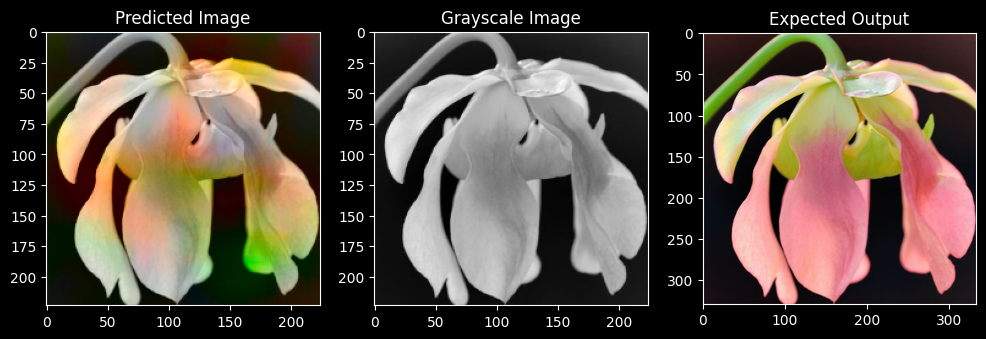

In [22]:
pth = '/content/data/natural_images/flower/flower_0038.jpg'.format(ind)

T = np.array(Image.open(pth))

g_img = Image.open(pth).convert('L')

test = g_img.save("test.jpg")

files = ['test.jpg']
for idx, file in enumerate(files):
    test = img_to_array(load_img(file))
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    vggpred = newmodel.predict(L)
    ab = model.predict(vggpred)
    ab = ab*255
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12, 12)
axes[0].set_title('Predicted Image')
im0 = axes[0].imshow(lab2rgb(cur))
axes[1].set_title('Grayscale Image')
im1 = axes[1].imshow(test)
axes[2].set_title('Expected Output')
im2 = axes[2].imshow(T)

1/1 [==============================] - 0s 30ms/step


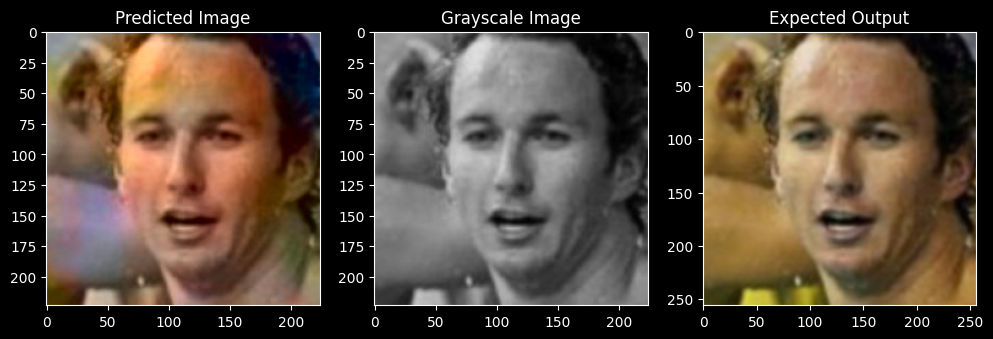

In [23]:
pth = '/content/data/natural_images/person/person_0006.jpg'.format(ind)

T = np.array(Image.open(pth))

g_img = Image.open(pth).convert('L')

test = g_img.save("test.jpg")

files = ['test.jpg']
for idx, file in enumerate(files):
    test = img_to_array(load_img(file))
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    vggpred = newmodel.predict(L)
    ab = model.predict(vggpred)
    ab = ab*255
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12, 12)
axes[0].set_title('Predicted Image')
im0 = axes[0].imshow(lab2rgb(cur))
axes[1].set_title('Grayscale Image')
im1 = axes[1].imshow(test)
axes[2].set_title('Expected Output')
im2 = axes[2].imshow(T)

1/1 [==============================] - 0s 30ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 418 pixels
  return func(*args, **kwargs)


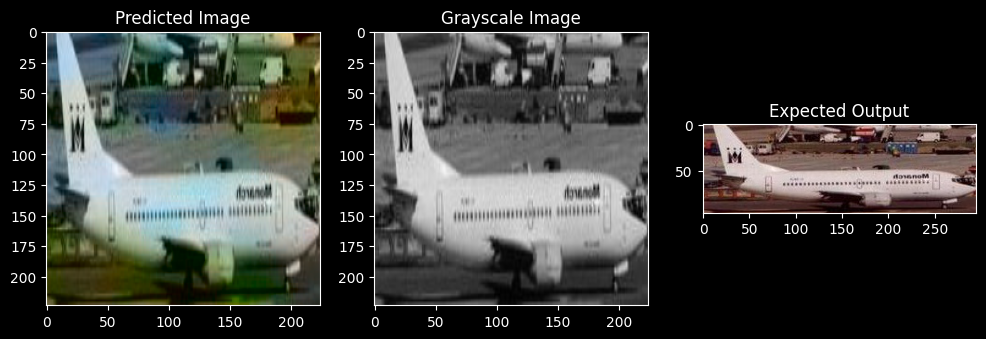

In [24]:
pth = '/content/data/natural_images/airplane/airplane_0072.jpg'.format(ind)

T = np.array(Image.open(pth))

g_img = Image.open(pth).convert('L')

test = g_img.save("test.jpg")

files = ['test.jpg']
for idx, file in enumerate(files):
    test = img_to_array(load_img(file))
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    vggpred = newmodel.predict(L)
    ab = model.predict(vggpred)
    ab = ab*255
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12, 12)
axes[0].set_title('Predicted Image')
im0 = axes[0].imshow(lab2rgb(cur))
axes[1].set_title('Grayscale Image')
im1 = axes[1].imshow(test)
axes[2].set_title('Expected Output')
im2 = axes[2].imshow(T)

1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 73 pixels
  return func(*args, **kwargs)


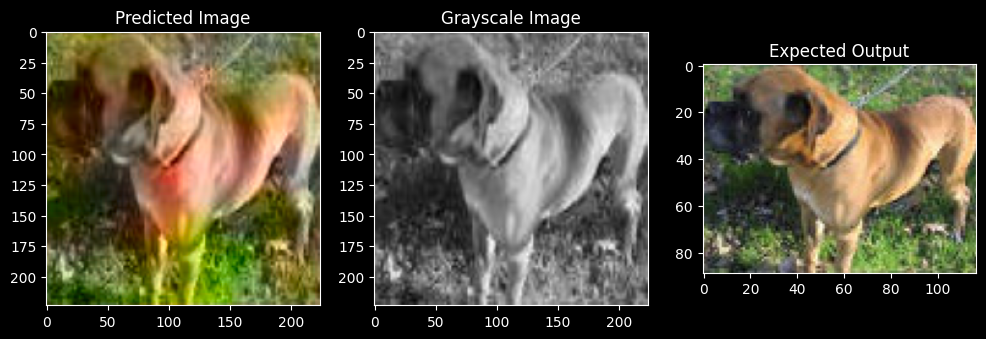

In [25]:
pth = '/content/data/natural_images/dog/dog_0000.jpg'.format(ind)

T = np.array(Image.open(pth))

g_img = Image.open(pth).convert('L')

test = g_img.save("test.jpg")

files = ['test.jpg']
for idx, file in enumerate(files):
    test = img_to_array(load_img(file))
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    vggpred = newmodel.predict(L)
    ab = model.predict(vggpred)
    ab = ab*255
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12, 12)
axes[0].set_title('Predicted Image')
im0 = axes[0].imshow(lab2rgb(cur))
axes[1].set_title('Grayscale Image')
im1 = axes[1].imshow(test)
axes[2].set_title('Expected Output')
im2 = axes[2].imshow(T)